In [85]:
"""
Running OC-SVM for anomaly detection using various frameworks

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py



"""
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

In [76]:
# Import X and Y data
x_data = pd.read_csv("X_data.csv")
y_data = np.loadtxt(open("Y_data.csv","rb"), delimiter=",")
y_labels = pd.read_csv("Y_labels.csv")
# Show first 5 rows of the data and print size

x_data.head()

,baro_alt_mean,rel_alt_mean,long_accel_x_mean,long_accel_x_max,long_accel_y_mean,long_accel_y_max,long_accel_z_mean,long_accel_z_max,heading_mean,velocity_x_mean,...,pitch_mean,pitch_max,long_first,long_mean,lat_first,lat_mean,airspeed_mean,airspeed_max,velocity_z_mean,velocity_z_max
0,360.892371,50.944007,-0.028786,2.794895,0.213080,1.892683,10.598565,24.085132,171.864475,0.680829,...,-2.768899,-24.961273,-79.897415,-79.898492,40.591882,40.592023,0.000000,0.000000,0.337147,8.315093
1,358.654817,48.485864,0.386346,3.579427,0.187522,1.265058,10.411942,19.936919,171.783456,-0.767343,...,0.700727,17.990290,-79.899496,-79.898199,40.591458,40.591769,15.588205,20.011089,0.208548,-5.309157
2,359.301311,49.132331,0.231368,-1.559257,0.196957,1.098345,9.969718,14.513842,179.783497,-2.187760,...,-0.494838,-14.817479,-79.895316,-79.898222,40.592245,40.591726,15.608605,18.666553,0.412222,4.599149
3,355.627224,46.968459,0.617460,3.442134,0.232400,1.333704,10.277100,24.369525,177.500349,-0.199078,...,1.718779,-20.920223,-79.898801,-79.898200,40.591750,40.592018,16.021075,26.180742,0.412889,7.926632
4,359.942800,51.281135,0.679240,2.824315,0.458977,1.461191,10.974028,15.013981,175.171270,1.851790,...,3.640776,14.562754,-79.895375,-79.895508,40.590641,40.590733,15.696847,20.183365,0.102976,-2.498319


In [77]:
# First we will run OC-SVM in a unsupervised environment (inliers and outliers together no labels)
# Fit model
outliers_fraction = 0.80
svm_obj = svm.OneClassSVM(
    kernel='rbf',
    nu = outliers_fraction,
    gamma = 0.1)

# 1: inliers, -1: Outliers
# 10 Samples are Non-failure
# 37 are Failure
x_np = x_data.to_numpy()
y_pred = svm_obj.fit(x_np).predict(x_np)

In [104]:
n_error_outliers = y_pred[y_pred == 1].size
print(n_error_outliers)
n_error_inliers = y_pred[y_pred == -1].size
print(n_error_inliers)
# 47 Total Flights, OC-SVM Detected 15 as Outlier and 32 as Inlier. 
# 32 being failure and 15 being normal

15
32


In [79]:
# Helper functions to get error types and performance statistics
def get_accuracy(y_truth, y_est, sample_size):
    """
        Function to compute accuracy on how well the classification algorithm works

        Returns accuracy
    """
    acc = 0
    for i in range(len(y_truth)):
        acc = acc + (y_truth[i] == y_est[i])
    acc = (1/sample_size) * acc

    return acc

In [129]:
acc = get_accuracy(y_data, y_pred, y_data.size)
print(acc*100)

63.829787234042556


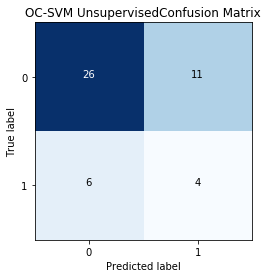

In [130]:


# Get Confusion matrix plot
def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Remap the classes
# 0: Inlier, 1: Outlier
y_data_new = np.where(np.array(y_data)==-1,0,1)
y_pred_new = np.where(np.array(y_pred)==-1,0, 1)
fig1, ax1 = plt.subplots()
plot_cm(ax1, y_data_new, y_pred_new, [0, 1], "OC-SVM Unsupervised Confusion Matrix")

3
44
85.1063829787234


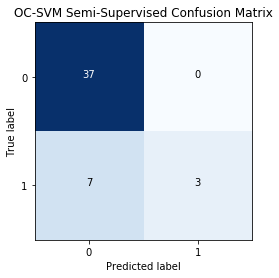

In [132]:
# Semi-Supervised OC-SVM
x_data_train = pd.read_csv("X_data_train.csv")
x_np = x_data_train.to_numpy()

outliers_fraction = 0.50
svm_obj = svm.OneClassSVM(
    kernel='rbf',
    nu = outliers_fraction,
    gamma = 0.1)
svm_obj.fit(x_np)
y_pred_ss = svm_obj.predict(x_data)

n_error_outliers = y_pred_ss[y_pred_ss == 1].size
print(n_error_outliers)
n_error_inliers = y_pred_ss[y_pred_ss == -1].size
print(n_error_inliers)
# 47 Total Flights, OC-SVM Detected 2 as Abnormal and 45 as Normal. 
acc = get_accuracy(y_data, y_pred_ss, y_data.size)
print(acc*100)
# Remap the classes
# 0: Inlier, 1: Outlier
y_data_new = np.where(np.array(y_data)==-1,0,1)
y_pred_new_ss = np.where(np.array(y_pred_ss)==-1,0, 1)
fig2, ax2 = plt.subplots()
plot_cm(ax2, y_data_new, y_pred_new_ss, [0, 1], "OC-SVM Semi-Supervised Confusion Matrix")